#Caso de Estudio: Clasificación de Cubiertas Urbanas en Quimbaya

Este caso de estudio consiste en la clasificación de cubiertas en el municipio de Quimbaya (Quindío), identificando tres materiales principales: zinc, eternit y barro, mediante redes neuronales convolucionales (CNN). La metodología es patch-based, por lo que no se trata de segmentación, sino de la clasificación de ventanas de la imagen, donde cada ventana recibe una única categoría según el material predominante.

## Cargue librerias

In [1]:
%%capture
!pip install -q gdown
!pip install rasterio

In [2]:
import re
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


## Lectura y exploración de datos

Se descarga un archivo ZIP desde Google Drive usando su ID, evita que se muestren mensajes en pantalla y luego descomprime el archivo en la carpeta de trabajo para poder usar su contenido.

In [3]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [4]:
%%capture
# Enlace: https://drive.google.com/file/d/1TMmPuZwB4UC96igymAYubE32opvRTaVq/view?usp=sharing
file_id = "1TMmPuZwB4UC96igymAYubE32opvRTaVq"
output_zip = "NPY_QUIMBAYA.zip"

# Descargardesde Google Drive
!gdown --id {file_id} -O {output_zip}

!unzip -o {output_zip} -d /content/



In [5]:
!rm /content/*.zip

In [6]:
X_quimbaya = np.load('/content/X_quimbaya.npy')
Y_quimbaya = np.load('/content/Y_quimbaya.npy')

print("Tamaño X_quimbaya:", X_quimbaya.shape)
print("Tamaño Y_quimbaya:", Y_quimbaya.shape)



Tamaño X_quimbaya: (915, 64, 64, 4)
Tamaño Y_quimbaya: (915,)


In [7]:
LABEL, conteos = np.unique(Y_quimbaya, return_counts=True)
total_muestras = np.sum(conteos)


porcentajes = (conteos / total_muestras) * 100

for LABEL, conteo,porcentajes in zip(LABEL, conteos,porcentajes):
    print(f"Categoría {LABEL}: {conteo} muestras, {round(porcentajes,1)} %")

Categoría BARRO: 332 muestras, 36.3 %
Categoría ETERNIT: 304 muestras, 33.2 %
Categoría ZINC: 279 muestras, 30.5 %


In [8]:
print(X_quimbaya[0].shape)
print('Muestra la banda 4')
X_quimbaya[0][:,:,3]

(64, 64, 4)
Muestra la banda 4


array([[ 92.,  97.,  84., ..., 212., 217., 205.],
       [103.,  89.,  80., ..., 199., 193., 192.],
       [ 79.,  95., 114., ..., 184., 183., 167.],
       ...,
       [ 18.,  18.,  17., ...,  43.,  43.,  43.],
       [ 18.,  17.,  17., ...,  43.,  43.,  43.],
       [ 18.,  17.,  17., ...,  43.,  43.,  43.]], dtype=float32)

In [9]:
total_wind=len(Y_quimbaya)
total_wind

915

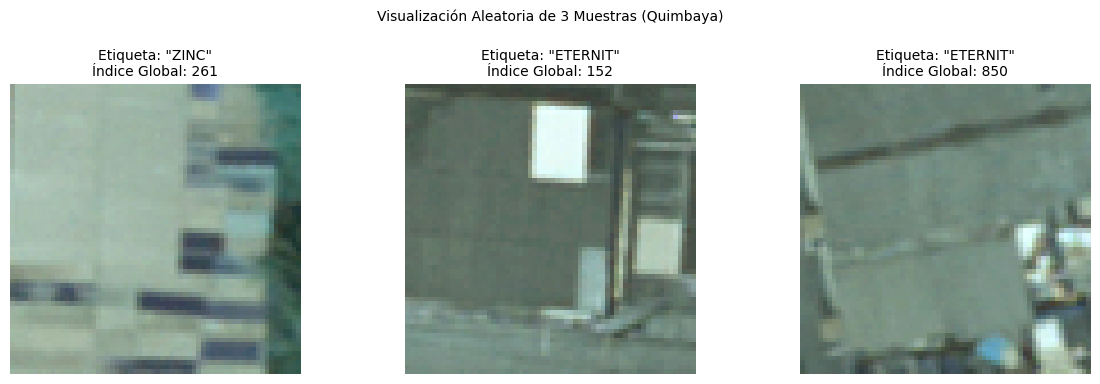

In [10]:
num_wind = 3  # N° ventadas a mostrar d
R_BAND = 2
G_BAND = 1
B_BAND = 0


num_samples = min(num_wind, total_wind)

#Obtener índices aleatorios sin reemplazo
random_indices = np.random.choice(total_muestras, size=num_samples, replace=False)
fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))

if num_samples == 1:
    axes = [axes]

fig.suptitle(f'Visualización Aleatoria de {num_samples} Muestras (Quimbaya)', fontsize=10)

# Iterar sobre los índices aleatorios y dibujar
for i, index in enumerate(random_indices):
    patch = X_quimbaya[index]
    label = Y_quimbaya[index]

    # Preprocesamiento RGB: Seleccionar bandas
    rgb_composite = patch[:, :, [R_BAND, G_BAND, B_BAND]]
    rgb_composite = rgb_composite / 255.0


    ax = axes[i]
    ax.imshow(rgb_composite)
    ax.set_title(f'Etiqueta: "{label}"\nÍndice Global: {index}', fontsize=10)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Divison conjunto de entrenamiento y test

Transformar  las etiquetas en números y luego en formato one-hot para que la red neuronal pueda usarlas.

In [11]:
label_encoder = LabelEncoder()
Y_integers = label_encoder.fit_transform(Y_quimbaya)
Y_one_hot = to_categorical(Y_integers)
num_class = Y_one_hot.shape[1]
num_class


3

In [12]:
print(f'Etiqueta original: {Y_quimbaya[3]},label_encoder: {Y_integers[3],},one hot: {Y_one_hot[3]}  ')

Etiqueta original: ETERNIT,label_encoder: (np.int64(1),),one hot: [0. 1. 0.]  


In [13]:
for i, clase in enumerate(label_encoder.classes_):
    print(i, clase)

0 BARRO
1 ETERNIT
2 ZINC


In [14]:
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(
    X_quimbaya, Y_one_hot, test_size=0.2, random_state=42
)

print(f"Dimensiones X_train: {X_train_raw.shape}")
print(f"Dimensiones X_test: {X_test_raw.shape}")
print(f"Dimensiones Y_train: {Y_train.shape}")
print(f"Dimensiones Y_test: {Y_test.shape}")

Dimensiones X_train: (732, 64, 64, 4)
Dimensiones X_test: (183, 64, 64, 4)
Dimensiones Y_train: (732, 3)
Dimensiones Y_test: (183, 3)


# Entrenamiento

In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

Configuración de parametros

In [16]:
input_shape = (64, 64, 4)
num_class = 3
epochs = 50    # Número de épocas para entrenar
batch_size = 32   # Tamaño del lote
random_state = 42

In [17]:
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train_raw, Y_train, test_size=0.125, random_state=random_state
)

print(f"Dimensión X_train_final (Entrenamiento): {X_train_final.shape}")
print(f"Dimensión X_val (Validación 10%):        {X_val.shape}")
print(f"Dimensión X_test_raw (Prueba 20%):       {X_test_raw.shape}")


Dimensión X_train_final (Entrenamiento): (640, 64, 64, 4)
Dimensión X_val (Validación 10%):        (92, 64, 64, 4)
Dimensión X_test_raw (Prueba 20%):       (183, 64, 64, 4)


Generar variaciones aleatorias de las imágenes de entrenamiento (aumentación de datos) para que el modelo aprenda a generalizar mejor, mientras normaliza los valores de píxel y organiza los datos en lotes para el entrenamiento.

Cada batch_size contiene 32 imágenes, con la aumentación de ImageDataGenerator, esas 32 imágenes se transforman aleatoriamente en cada iteración, por lo que aunque sean las mismas originales, el modelo las ve distintas cada vez.

* Datos originales: 640 imágenes.

* Batches por época: 640/32=20.

* Épocas: 50.

* Iteraciones totales: 20 × 50 = 1000 pasos de entrenamiento.

El modelo entrena 1000 veces sobre variaciones de las 640 imágenes, sin duplicar los datos físicamente.

In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,          # Normaliza los valores de píxel de [0–255] a [0–1].
    rotation_range=20,       # Rota las imágenes aleatoriamente hasta ±20°.
    width_shift_range=0.1,   # Desplaza la imagen horizontalmente hasta un 10%.
    height_shift_range=0.1,  # Desplaza la imagen verticalmente hasta un 10%.
    shear_range=0.1,         # Aplica un corte (shear) de hasta 10%.
    zoom_range=0.1,          # Realiza un zoom aleatorio de ±10%.
    horizontal_flip=True,    # Invierte las imágenes horizontalmente.
    fill_mode='nearest'      # Rellena los píxeles vacíos usando los valores más cercanos.
)

train_generator = datagen.flow(
    X_train_final,   # Imágenes de entrenamiento.
    Y_train_final,   # Etiquetas correspondientes.
    batch_size=batch_size,  # Tamaño del lote (número de imágenes por iteración).
    shuffle=True     # Mezcla aleatoriamente las imágenes en cada época.
)


Preparar los datos de validación (solo escalado, sin Data Augmentation)

In [19]:

validation= (X_val / 255.0, Y_val)
X_test= X_test_raw / 255.0


In [20]:
from tensorflow.keras.initializers import GlorotNormal

def configurar_entorno(seed=42):
    """
    Configura la semilla global para garantizar reproducibilidad
    en todos los experimentos con TensorFlow, NumPy y Python.

    Parámetros
    ----------
    seed : int
        Valor de la semilla a utilizar (por defecto 42).
    """

    # Fija la semilla de generadores aleatorios

    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Crea un inicializador global que puedes reutilizar en tus modelos
    global global_initializer
    global_initializer = GlorotNormal(seed=seed)

    print(f"Semilla configurada correctamente (valor = {seed})")



In [21]:
configurar_entorno(42)

Semilla configurada correctamente (valor = 42)


## Entrenamiento Red

In [22]:
model = Sequential([
    Conv2D(128, (5,5), activation='relu', padding='same',input_shape=input_shape, strides=(1,1),kernel_initializer=global_initializer),
    MaxPooling2D((2,2)),

    Conv2D(64, (5,5), activation='sigmoid', padding='same',strides=(1,1), kernel_initializer=global_initializer),
    MaxPooling2D((2,2)),

    Conv2D(32, (5,5), activation='tanh', padding='same',kernel_initializer=global_initializer),
    BatchNormalization(),

    Flatten(),
    Dense(32, activation='relu', kernel_initializer=global_initializer),
    Dense(num_class, activation='softmax', kernel_initializer=global_initializer)
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=X_train_final.shape[0] // batch_size,
    epochs=epochs,
    validation_data=validation # Usar el conjunto X_val y Y_val
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.3988 - loss: 2.1461 - val_accuracy: 0.3261 - val_loss: 1.9872
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6864 - loss: 0.6584 - val_accuracy: 0.3587 - val_loss: 2.4718
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8464 - loss: 0.3905 - val_accuracy: 0.3370 - val_loss: 1.9059
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8968 - loss: 0.2553 - val_accuracy: 0.6196 - val_loss: 1.6879
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9218 - loss: 0.2204 - val_accuracy: 0.3804 - val_loss: 2.2873
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9027 - loss: 0.2615 - val_accuracy: 0.3804 - val_loss: 2.2269
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9231 - loss: 0.1943 - val_accuracy: 0.3261 - val_loss: 4.3593
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8993 - loss: 0.2491 - val_accuracy: 0.3696 - val_loss: 

In [24]:
def plot_training_history(history):
    """
    Grafica la precisión y la pérdida del modelo durante el entrenamiento y la validación.

    """
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].plot(history.history['accuracy'], label='Entrenamiento')
    ax[0].plot(history.history['val_accuracy'], label='Validación')
    ax[0].set_title('Accuracy del modelo')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(history.history['loss'], label='Entrenamiento')
    ax[1].plot(history.history['val_loss'], label='Validación')
    ax[1].set_title('Pérdida del modelo')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    return fig, ax


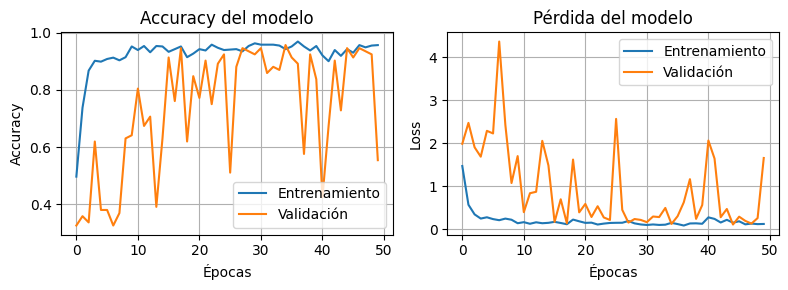

(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy del modelo'}, xlabel='Épocas', ylabel='Accuracy'>,
        <Axes: title={'center': 'Pérdida del modelo'}, xlabel='Épocas', ylabel='Loss'>],
       dtype=object))

In [25]:
plot_training_history(history)

In [26]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step


In [27]:
def plot_classification_results(Y_true, Y_pred_classes, label_encoder):
    """
    Genera el reporte de clasificación y la matriz de confusión a partir de las etiquetas reales y predichas.
    """
    # Obtener nombres de las clases
    class_names = label_encoder.classes_


    print('Reporte de clasificación:')
    print(classification_report(Y_true, Y_pred_classes, target_names=class_names))


    cm = confusion_matrix(Y_true, Y_pred_classes)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matriz de confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return

Reporte de clasificación:
              precision    recall  f1-score   support

       BARRO       0.55      1.00      0.71        68
     ETERNIT       0.30      0.13      0.18        60
        ZINC       0.88      0.53      0.66        55

    accuracy                           0.57       183
   macro avg       0.58      0.55      0.52       183
weighted avg       0.57      0.57      0.52       183



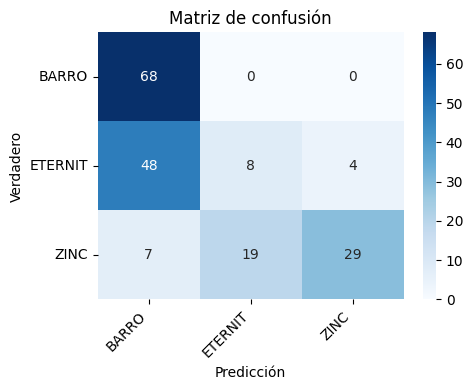

In [28]:
plot_classification_results(Y_true, Y_pred_classes, label_encoder)

## Regularización DROPOUT

In [29]:
modeldrop = Sequential([
    Conv2D(128, (5,5), activation='relu', padding='same',input_shape=input_shape, strides=(1,1), kernel_initializer=global_initializer),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (5,5), activation='sigmoid', padding='same',strides=(1,1), kernel_initializer=global_initializer),
    MaxPooling2D((2,2)),

    Conv2D(32, (5,5), activation='tanh', padding='same',kernel_initializer=global_initializer),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(32, activation='relu', kernel_initializer=global_initializer),
    Dropout(0.4),
    Dense(num_class, activation='softmax', kernel_initializer=global_initializer)
])

modeldrop.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']

)
historydrop = modeldrop.fit(train_generator,steps_per_epoch=X_train_final.shape[0] // batch_size,epochs=epochs,validation_data=validation)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.3018 - loss: 2.3932 - val_accuracy: 0.3261 - val_loss: 1.1690
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5268 - loss: 1.0028 - val_accuracy: 0.3913 - val_loss: 0.9045
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6177 - loss: 0.7776 - val_accuracy: 0.5109 - val_loss: 0.8967
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6356 - loss: 0.6921 - val_accuracy: 0.5109 - val_loss: 0.8364
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6138 - loss: 0.6338 - val_accuracy: 0.3152 - val_loss: 1.3329
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6408 - loss: 0.6627 - val_accuracy: 0.3804 - val_loss: 1.2410
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5908 - loss: 0.6581 - val_accuracy: 0.5109 - val_loss: 0.8404
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6753 - loss: 0.6121 - val_accuracy: 0.3696 - val_loss: 1

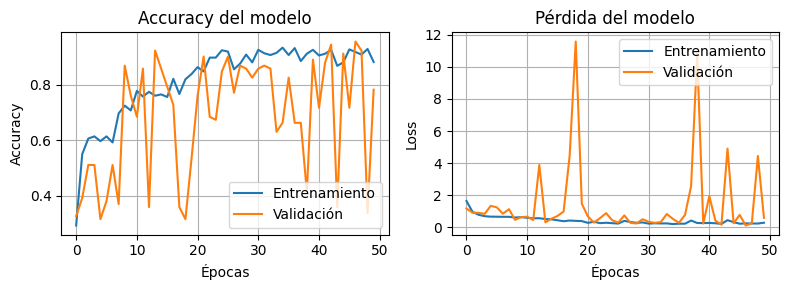

(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy del modelo'}, xlabel='Épocas', ylabel='Accuracy'>,
        <Axes: title={'center': 'Pérdida del modelo'}, xlabel='Épocas', ylabel='Loss'>],
       dtype=object))

In [30]:
plot_training_history(historydrop)

In [31]:
Y_predrop = modeldrop.predict(X_test)
Y_predrop_classes = np.argmax(Y_predrop, axis=1)
Y_true = np.argmax(Y_test, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


Reporte de clasificación:
              precision    recall  f1-score   support

       BARRO       0.92      1.00      0.96        68
     ETERNIT       0.68      0.90      0.77        60
        ZINC       1.00      0.53      0.69        55

    accuracy                           0.83       183
   macro avg       0.86      0.81      0.81       183
weighted avg       0.86      0.83      0.82       183



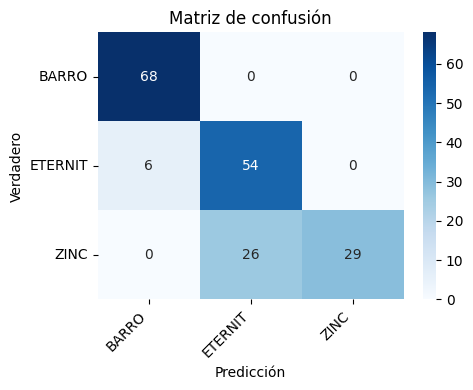

In [32]:
plot_classification_results(Y_true, Y_predrop_classes, label_encoder)

## Regularización L1

In [33]:
from tensorflow.keras.regularizers import l1


modell1 = Sequential([
    Conv2D(128, (5,5), activation='relu', padding='same',input_shape=input_shape, strides=(1,1),kernel_initializer=global_initializer,
           kernel_regularizer=l1(1e-4)),
    MaxPooling2D((2,2)),

    Conv2D(64, (5,5), activation='sigmoid', padding='same',strides=(1,1), kernel_initializer=global_initializer,kernel_regularizer=l1(1e-4)),
    MaxPooling2D((2,2)),

    Conv2D(32, (5,5), activation='tanh', padding='same',kernel_initializer=global_initializer, kernel_regularizer=l1(1e-4)),
    BatchNormalization(),

    Flatten(),
    Dense(32, activation='relu',kernel_initializer=global_initializer, kernel_regularizer=l1(1e-4)),
    Dense(num_class, activation='softmax', kernel_initializer=global_initializer)
])

modell1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

historyl1 = modell1.fit(train_generator,steps_per_epoch=X_train_final.shape[0] // batch_size,epochs=epochs,validation_data=validation)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.4375 - loss: 2.9359 - val_accuracy: 0.3370 - val_loss: 1.8487
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8154 - loss: 1.1335 - val_accuracy: 0.4348 - val_loss: 1.8074
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7888 - loss: 1.0883 - val_accuracy: 0.6196 - val_loss: 1.1605
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9097 - loss: 0.7867 - val_accuracy: 0.5761 - val_loss: 1.2550
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9045 - loss: 0.7533 - val_accuracy: 0.6304 - val_loss: 1.3742
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9035 - loss: 0.7044 - val_accuracy: 0.4348 - val_loss: 1.4525
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9103 - loss: 0.6662 - val_accuracy: 0.5217 - val_loss: 1.9390
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8999 - loss: 0.7026 - val_accuracy: 0.6196 - val_loss: 2

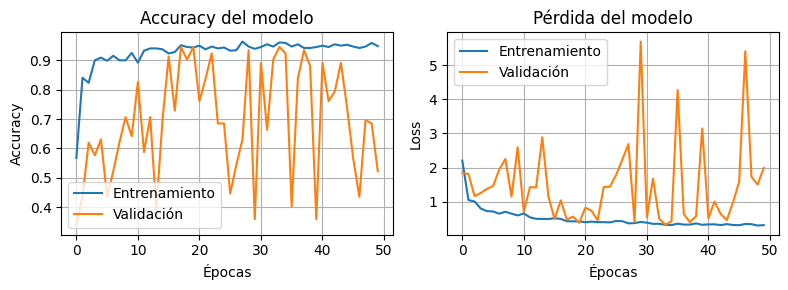

(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy del modelo'}, xlabel='Épocas', ylabel='Accuracy'>,
        <Axes: title={'center': 'Pérdida del modelo'}, xlabel='Épocas', ylabel='Loss'>],
       dtype=object))

In [34]:
plot_training_history(historyl1)

In [35]:
Y_prel1 = modell1.predict(X_test)
Y_prel1_classes = np.argmax(Y_prel1, axis=1)
Y_true = np.argmax(Y_test, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


Reporte de clasificación:
              precision    recall  f1-score   support

       BARRO       0.60      1.00      0.75        68
     ETERNIT       0.42      0.27      0.33        60
        ZINC       0.97      0.55      0.70        55

    accuracy                           0.62       183
   macro avg       0.66      0.60      0.59       183
weighted avg       0.65      0.62      0.59       183



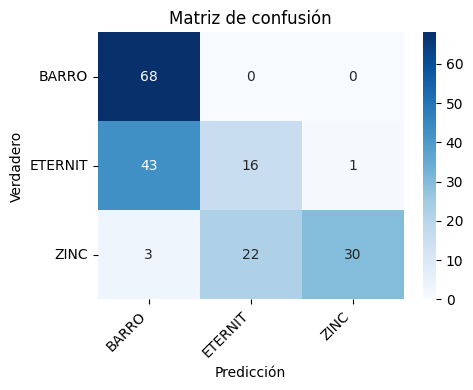

In [36]:
plot_classification_results(Y_true, Y_prel1_classes, label_encoder)

## Regularización L2

In [37]:
from tensorflow.keras.regularizers import l2


modell2 = Sequential([
    Conv2D(128, (5,5), activation='relu', padding='same',input_shape=input_shape, strides=(1,1),
           kernel_initializer=global_initializer, kernel_regularizer=l2(1e-4)),
    MaxPooling2D((2,2)),

    Conv2D(64, (5,5), activation='sigmoid', padding='same',strides=(1,1), kernel_initializer=global_initializer,kernel_regularizer=l2(1e-4)),
    MaxPooling2D((2,2)),

    Conv2D(32, (5,5), activation='tanh', padding='same',kernel_initializer=global_initializer, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),

    Flatten(),
    Dense(32, activation='relu',kernel_initializer=global_initializer, kernel_regularizer=l2(1e-3)),
    Dense(num_class, activation='softmax', kernel_initializer=global_initializer)
])

modell2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

historyl2 = modell1.fit(train_generator,steps_per_epoch=X_train_final.shape[0] // batch_size,epochs=epochs,validation_data=validation)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8823 - loss: 0.5491 - val_accuracy: 0.6848 - val_loss: 0.7847
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9265 - loss: 0.3683 - val_accuracy: 0.8696 - val_loss: 0.8467
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9209 - loss: 0.4698 - val_accuracy: 0.9022 - val_loss: 0.6028
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9461 - loss: 0.3231 - val_accuracy: 0.6630 - val_loss: 0.7821
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9551 - loss: 0.3059 - val_accuracy: 0.7935 - val_loss: 0.8069
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9573 - loss: 0.3131 - val_accuracy: 0.8043 - val_loss: 0.9685
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9572 - loss: 0.2993 - val_accuracy: 0.7935 - val_loss: 0.8318
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9594 - loss: 0.2776 - val_accuracy: 0.9022 - val_loss: 0.

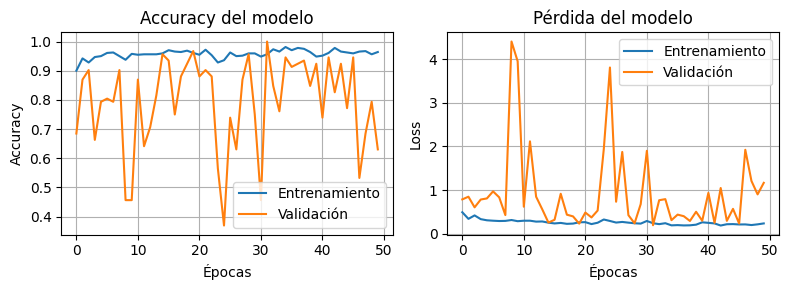

(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy del modelo'}, xlabel='Épocas', ylabel='Accuracy'>,
        <Axes: title={'center': 'Pérdida del modelo'}, xlabel='Épocas', ylabel='Loss'>],
       dtype=object))

In [38]:
plot_training_history(historyl2)

In [39]:
Y_prel2 = modell2.predict(X_test)
Y_prel2_classes = np.argmax(Y_prel2, axis=1)
Y_true = np.argmax(Y_test, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


Reporte de clasificación:
              precision    recall  f1-score   support

       BARRO       0.00      0.00      0.00        68
     ETERNIT       0.33      1.00      0.49        60
        ZINC       0.00      0.00      0.00        55

    accuracy                           0.33       183
   macro avg       0.11      0.33      0.16       183
weighted avg       0.11      0.33      0.16       183



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


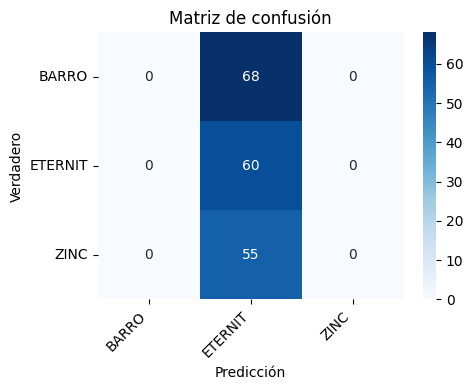

In [40]:
plot_classification_results(Y_true, Y_prel2_classes, label_encoder)

# Actividad:

1. Diseño del modelo: Diseña y entrena tu propia red neuronal usando tu conjunto de datos del municipio de Quimbaya. Implementa varía las funciones de activación (ReLU, tanh, sigmoide) junto con las técnicas de regularización (Dropout, L2 o BatchNormalization).Modifica también el número de épocas de entrenamiento.

2. Evaluación y análisis: Evalúa cada modelo registrando métricas de desempeño como precisión, pérdida o F1-score. Compara los resultados obtenidos y redacta una breve conclusión sobre cuál combinación de activación y regularización logró el mejor equilibrio entre precisión y generalización.